<a href="https://colab.research.google.com/github/Mandy-cyber/Period-Pride-Ja-NN/blob/main/TwoForOneGrand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This is to download the dataset files from google drive - only need to do this when runtime session is over
!wget -q https://drive.google.com/uc?id=1SxawUdXzsQHYxavMedDln8HY2tPMI3vt&export=download
!wget -q https://drive.google.com/uc?id=13Qe4fGKUvCdcqpoJhb2Zq5o3Is1HwhY5&export=download

In [ ]:
import pandas as pd
import string
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from sklearn import metrics
import time
nltk.download('stopwords')
nltk.download('wordnet')

## **LOADING & PRE-PROCESSING DATA**




In [ ]:
#LOADING DATASETS
# N.B - Cannot merge datasets since their different categories are augmented differently and it wouldn't all add up properly
df_sentiment = pd.read_csv('uc?id=13Qe4fGKUvCdcqpoJhb2Zq5o3Is1HwhY5') 
df_category = pd.read_csv('fullCategoryAugDataset.csv') #uc?id=1SxawUdXzsQHYxavMedDln8HY2tPMI3vt

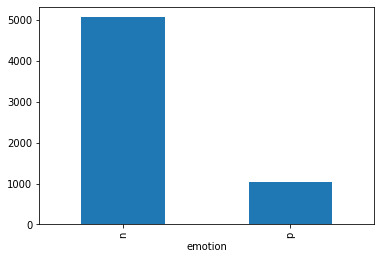

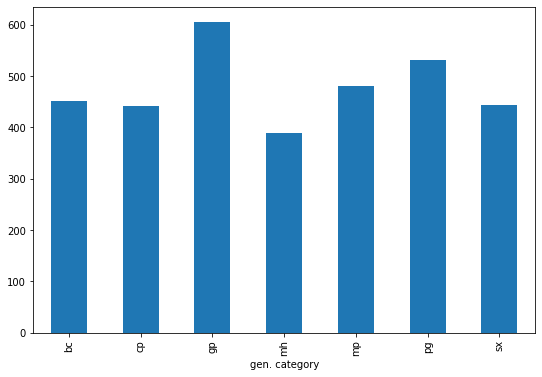

In [ ]:
#VISUALIZING DATA (can be commented out or cell not run)
#We do this to tell how even (or not even) the data in the different categories are
fig = plt.figure() 
df_sentiment.groupby('emotion').headingText.count().plot.bar(ylim=0)
plt.show()

fig = plt.figure(figsize=(9,6))
df_category.groupby('gen. category').headingText.count().plot.bar(ylim=0)
plt.show()

In [ ]:
#PRE-PROCESSING FUCNTIONS
# Needed to make text more easily 'digestible' by the system
stopWords = nltk.corpus.stopwords.words('english') #establishing the stopwords corpus (collection of words)
wn = nltk.WordNetLemmatizer() #using lemmatizer instead of stemming because lemmatizer = more accurate (only downfall is speed)
def clean_up(text):
    noPunctText = "".join([c for c in str(text) if c not in string.punctuation]) #removing punctuation
    tokens = re.split('\W+', str(noPunctText)) #Use the punctuation-free text to split into separate words (tokens)
    noStopWords = [word for word in tokens if word not in stopWords] #remove stop words e.g 'and'
    text_nsw = [each_string.lower() for each_string in noStopWords] #make all the words lowercase
    lem_text = [wn.lemmatize(word) for word in text_nsw] #lemmatize the words (i.e bring the words back to their roots)
    return lem_text

In [ ]:
#APPLYING PRE-PROCESSING FUNCTION TO THE RELEVANT COLUMNS
df_sentiment['headingTextClean'] = df_sentiment['headingText'].apply(clean_up) #applying function
dfSenNew = df_sentiment[['headingTextClean', 'emotion']] #Creating a new dataframe with only the 2 columns we need

# Repeat same process as above but with the second dataset
df_category['headingTextClean'] = df_category['headingText'].apply(clean_up)
dfCatNew = df_category[['headingTextClean', 'gen. category']]
# dfNew.head()

#TOKENIZING THE TEXTS (splitting into individual words/tokens)
tk = Tokenizer()
tk.fit_on_texts(dfSenNew['headingTextClean'].values)
tk.fit_on_texts(dfCatNew['headingTextClean'].values)

## **CREATING THE MODEL**

> #### *Splitting into training & testing, fitting model, and getting the evaluation*

In [ ]:
#Using Sequential because our models will each only be fitted with a plain stack of layers (i.e one input only maps to one output)
model1 = Sequential()
model2 = Sequential()
labels1 = ['p', 'n'] #for emotion category
labels2 = ['gp', 'pg', 'mp', 'bc', 'mh', 'cp', 'sx'] #for general category

# [dfSenNew, 'emotion', 2, model1, labels1], 
infoSets = [[dfCatNew, 'gen. category', 7, model2, labels2]] #to be used in for loop

for z in infoSets:
  #IDENTIFYING THE FEATURES AND THE LABELS
  X = tk.texts_to_sequences(z[0]['headingTextClean'].values) #converting the features (inputs) to a numpy array
  X = pad_sequences(X) #pads sequences to the same length to avoid mismatch dimension error
  y = pd.get_dummies(z[0][z[1]]).values #giving the labels (outputs) numerical values so the system can understand it

  #--------------------------------------------------------------------------------------------------------------------------#
  #SPLITTING INTO TESTING & TRAINING DATA
  X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 5) #Allocating 20% of data to testing, and shuffling order 5 times
  # print(X_train.shape, y_train.shape)
  # print(X_test.shape, y_test.shape)
  # ^^just making sure the dimensions were matching up

  #--------------------------------------------------------------------------------------------------------------------------#
  #VARS THAT ARE REQUIREMENTS FOR THE EMBEDDING LAYER
  MAX_NB_WORDS = 4000 #this variable is not really necessary for our situation but since the model needs it we just assigned a high number
  EMBEDDING_DIM = 128 #this value can also be changed, we just used 128 as a default value telling the model what size the vector dimensions should be

  #--------------------------------------------------------------------------------------------------------------------------#
  #MODEL CONFIGURATION
  #Using an embedding input layer so words with the same meanings are given similar representations, and the vector dimensions are smaller
  z[3].add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1])) #input layer
  z[3].add(SpatialDropout1D(0.2))#We use dropout to prevent overfitting (modelling the training data too well)
  z[3].add(LSTM(100, dropout=0.2, recurrent_dropout=0.2)) 
  z[3].add(Dense(z[2], activation='softmax')) #Softmax is the type of activation function
  z[3].compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #identify loss function and the optimizer. want accuracy to be the metric evaluated
  # We use categorical_crossentropy because for both datasets as there are two or more possible outputs
  # Use adam function

  #--------------------------------------------------------------------------------------------------------------------------#
  #HYPER-PARAMTERS
  epochs = 5 
  batch_size = 64 #default batch_size
  history = z[3].fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1) #fitting the model with all its yummy parameters
  
  #--------------------------------------------------------------------------------------------------------------------------#
  #EVALUATION & ACCURACY
  accr = z[3].evaluate(X_test,y_test) #evaluating the model by using the testing data 
  print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1])) #printing the loss and accuracy values for the testing data (to compare with training data)

## **USER INPUT**

> #### *Testing the model with user input*


In [ ]:
#MAKE PREDICTIONS FROM FIXED OR USER INPUT
new_question = ["i am stressed out, because this is not working"]
seq = tk.texts_to_sequences(new_question)
paddedQuestion = pad_sequences(seq)
for z in infoSets:
  pred = z[3].predict(paddedQuestion)
  labels = z[4]
  # print(pred)
  print(labels[np.argmax(pred)])

mp
